# *Monod* analysis

In the current notebook, we take the results of the *Monod* inference pipeline and compare the likelihood ratios between models. We inspect a series of human liver and mouse neuron cell types, and consider Markovian and non-Markovian model fits between single-cell and single-nucleus data.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
# import sys
# sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
# import monod
# from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [1]:
# import pandas as pd
# import numpy as np
# import loompy as lp
# import matplotlib.pyplot as plt
# import scipy

## Load results and extract the key points

In [4]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm

In [5]:
import pymc3 as pm
import theano.tensor as tt
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import cme_toolbox

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, mx, data, likelihood,n_cells):
        
        # add inputs as class attributes
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        self.n_cells = n_cells
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.mx, self.data,self.n_cells) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood
def ll_bursty(p, mx, data,n_cells):
    return fitmodel_burst.eval_model_logL(p,mx,None,data,n_cells)
def ll_extrinsic(p, mx, data,n_cells):
    return fitmodel_ext.eval_model_logL(p,mx,None,data,n_cells)
def ll_delay(p, mx, data,n_cells):
    return fitmodel_delay.eval_model_logL(p,mx,None,data,n_cells)
def ll_delayedsplicing(p, mx, data,n_cells):
    return fitmodel_delsplic.eval_model_logL(p,mx,None,data,n_cells)
fitmodel_burst = monod.cme_toolbox.CMEModel('Bursty','None')
fitmodel_ext = monod.cme_toolbox.CMEModel('Extrinsic','None')
fitmodel_delay = monod.cme_toolbox.CMEModel('Delay','None')
fitmodel_delsplic = monod.cme_toolbox.CMEModel('DelayedSplicing','None')



these parameter names are wrong...

In [6]:
par_names_wrong = [['b','beta','gamma'],['alpha','beta','gamma'], ['alpha','beta','tauinv'],['alpha','tauinv','gamma']]



In [7]:
dir_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/raw/'
out_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/'
dataset_meta = ['B08','A02']
cluster_names = ['Glutamatergic','GABAergic']
allen_dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]
# allen_dataset_strings = [dir_string + '/' + x for x in dataset_names]
dataset_meta = ['sc','sn']

cluster_names = ['CentralHep','PortalHep','InterHep']
liver_dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]
# liver_dataset_strings = [x for x in dataset_names]
dataset_names = allen_dataset_names + liver_dataset_names

In [8]:
models = ['bursty','extrinsic','delay','delayedsplicing']
for dataset in tqdm(dataset_names):
    for model_ind,model in enumerate(models):
        raw_str = dir_string+dataset+'_'+model+'.pickle'
        out_str = out_string+dataset+'_'+model+'.pickle'
        
        with open(raw_str, 'rb') as f:
            trace_pickle = pickle.load(f)
            
        n_genes = len(trace_pickle)
        n_steps = 1000
        trace_variable_values = np.zeros((n_genes,3,n_steps))
        lml_values = np.zeros(n_genes)
        
        for i in range(n_genes):
            lml_values[i] = trace_pickle[i].report.log_marginal_likelihood
            for var_ in range(3):
                trace_variable_values[i,var_,:] = getattr(trace_pickle[i],par_names_wrong[model_ind][var_])
        with open(out_str, 'wb') as f:
            pickle.dump((trace_variable_values,lml_values),f)
        
                
#         print(raw_str)
#         print(out_str)
#         print('---')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:03:54<00:00, 383.44s/it]


In [93]:
# trace_pickle=bursty

In [61]:
# import numpy as np

In [63]:
# model_ind=0
# n_genes = len(trace_pickle)
# trace_variable_values = np.zeros((n_genes,3,1000))
# lml_values = np.zeros(n_genes)
# for i in range(n_genes):
#     lml_values[i] = trace_pickle[i].report.log_marginal_likelihood
#     for var_ in range(3):
#         trace_variable_values[i,var_,:] = getattr(trace_pickle[i],par_names_wrong[model_ind][var_])

## Reload

In [30]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from tqdm import tqdm
import scipy
from scipy import stats

In [25]:
dir_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/raw/'
out_string = '/home/ggorin/projects/GYP_2022/fits/smc_fits/'
dataset_meta = ['B08','A02']
cluster_names_allen = ['Glutamatergic','GABAergic']
allen_dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names_allen]
# allen_dataset_strings = [dir_string + '/' + x for x in dataset_names]
dataset_meta = ['sc','sn']

cluster_names = ['CentralHep','PortalHep','InterHep']
liver_dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]
# liver_dataset_strings = [x for x in dataset_names]
dataset_names = allen_dataset_names + liver_dataset_names

In [18]:
BFs_allen.shape

(4, 3, 1319)

In [19]:
models = ['bursty','extrinsic','delay','delayedsplicing']

out_str = out_string+allen_dataset_names[0]+'_'+models[0]+'.pickle'
with open(out_str, 'rb') as f:
    trace_variable_values,lml_values=pickle.load(f)
n_genes_allen = len(lml_values)

BFs_allen = np.zeros((len(allen_dataset_names),3,n_genes_allen))
BFs_liver = np.zeros((len(liver_dataset_names),3,n_genes_allen))

for dataset_ind,dataset in enumerate(allen_dataset_names):
    for model_ind,model in enumerate(models):
        out_str = out_string+dataset+'_'+model+'.pickle'
        with open(out_str, 'rb') as f:
            trace_variable_values,lml_values=pickle.load(f)
        if model_ind==0:
            LML_bursty = lml_values
        else:
            BFs_allen[dataset_ind,model_ind-1,:] = (lml_values-LML_bursty)/np.log(10)
        
                
#         print(raw_str)
#         print(out_str)
#         print('---')

In [26]:
BFs_allen.shape

(4, 3, 1319)

In [33]:
(BFs_allen>0).mean(2)

array([[0.29946929, 0.57391964, 0.        ],
       [0.41849886, 0.70507961, 0.0030326 ],
       [0.18271418, 0.37755876, 0.26686884],
       [0.24715694, 0.45943897, 0.27141774]])

extrinsic
Glutamatergic
GABAergic
delay
Glutamatergic
GABAergic
delayedsplicing
Glutamatergic
GABAergic


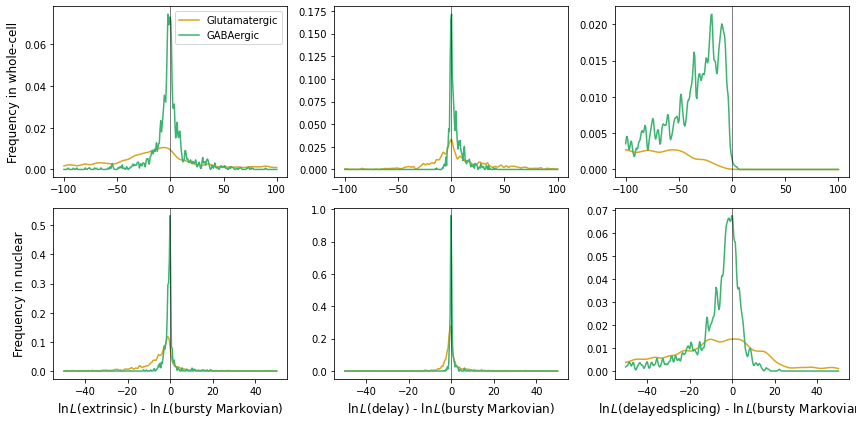

In [32]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','lightgray')
# cluster
model_names = models[1:]
kdes_allen = np.empty((3,2,2),dtype=object) #model, cell type, tech

for model_index in range(3):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,2],[1,3]]):
        print(cluster_names_allen[cluster_index])
        
        lim = 100
        linsp_n = 300
        sc_bf = BFs_allen[di[0],model_index]
        sc_kde=scipy.stats.gaussian_kde(sc_bf,bw_method=0.02)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names_allen[cluster_index]}',color=colors[cluster_index])
        
        lim = 50
        sn_bf = BFs_allen[di[1],model_index]
        sn_kde=scipy.stats.gaussian_kde(sn_bf,bw_method=0.02)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names_allen[cluster_index]}',color=colors[cluster_index])
        
        kdes_allen[model_index,cluster_index,0] = sc_kde
        kdes_allen[model_index,cluster_index,1] = sn_kde
        
        

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()
# plt.savefig('./fig/likelihood_ratio_allen.png',dpi=450)

In [ ]:
np.asarray(getattr(bursty[0],'beta')

In [55]:
len(bursty)

1319

In [59]:
trace_pickle[0].beta.shape

(1000,)

In [20]:
with open(st1, 'rb') as f:
    bursty = pickle.load(f)

In [ ]:
# with open(st2, 'rb') as f:
#     ext = pickle.load(f)

In [29]:
bursty[0].report.log_marginal_likelihood

array([-29050.06685558])

In [32]:
bursty[2].report.log_marginal_likelihood

array([-34889.12131901])

In [34]:
# with open(st2, 'rb') as f:
#     ext = pickle.load(f)

In [5]:
# sr_arr_full = [[monod.analysis.load_search_results(dataset_strings[i] + '/' + models[j] + '_None_1x1/grid_scan_results_upd.res') for j in range(len(models))] for i in range(n_datasets)]
# sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]
# model_logL = [[sr.get_logL(sd) for sr in x] for x,sd in zip(sr_arr_full,sd_arr)]
# model_logL = np.asarray(model_logL)

In [93]:
# tot_wc_allen = np.asarray([[sd_arr[j].layers[0].sum(),sd_arr[j].layers[1].sum()] for j in range(len(cluster_names))],dtype=float)
# tot_nuc_allen = np.asarray([[sd_arr[j+len(cluster_names)].layers[0].sum(),sd_arr[j+len(cluster_names)].layers[1].sum()] for j in range(len(cluster_names))],dtype=float)
# tot_wc_allen /= tot_wc_allen.sum(1)[:,None]
# tot_nuc_allen /= tot_nuc_allen.sum(1)[:,None]

In [94]:
# tot_wc_allen

array([[0.51285656, 0.48714344],
       [0.53391719, 0.46608281]])

In [95]:
# tot_nuc_allen

array([[0.88212849, 0.11787151],
       [0.87645038, 0.12354962]])

delayed deg.
Glutamatergic
GABAergic
extrinsic
Glutamatergic
GABAergic
delayed splic.
Glutamatergic
GABAergic


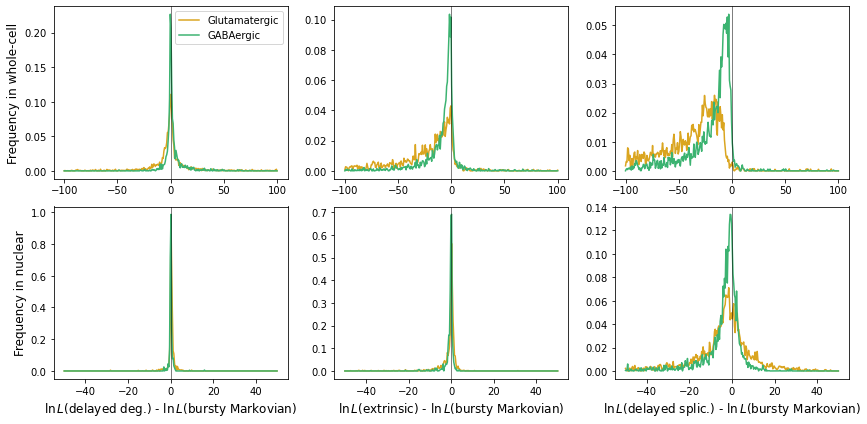

In [96]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','lightgray')

kdes_allen = np.empty((3,2,2),dtype=object) #model, cell type, tech

for model_index,mi in enumerate([[2,1],[0,1],[3,1]]):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,2],[1,3]]):
        print(cluster_names[cluster_index])
        
        lim = 100
        linsp_n = 300
        sc_lr=model_logL[di[0],mi[0]] - model_logL[di[0],1]
        sc_lr = sc_lr[np.abs(sc_lr)<lim]
        sc_kde=scipy.stats.gaussian_kde(sc_lr,bw_method=0.01)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        
        lim = 50
        sn_lr=model_logL[di[1],mi[0]] - model_logL[di[1],1]
        sn_lr = sn_lr[np.abs(sn_lr)<lim]
        sn_kde=scipy.stats.gaussian_kde(sn_lr,bw_method=0.01)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        
        kdes_allen[model_index,cluster_index,0] = sc_kde
        kdes_allen[model_index,cluster_index,1] = sn_kde
        
        

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()
plt.savefig('./fig/likelihood_ratio_allen.png',dpi=450)

## Liver

In [12]:
dataset_meta = ['sc','sn']
cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]
dir_string = './fits/gg_220909_024_liver_andrews_2'
dataset_strings = [dir_string + '/' + x for x in dataset_names]
models = ['Extrinsic','Bursty','Delay','DelayedSplicing']
model_names=('delayed deg.','extrinsic','delayed splic.')
n_models = len(models)
n_datasets = len(dataset_names)

In [13]:
sr_arr_full = [[monod.analysis.load_search_results(dataset_strings[i] + '/' + models[j] + '_None_1x1/grid_scan_results_upd.res') for j in range(len(models))] for i in range(n_datasets)]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]
model_logL = [[sr.get_logL(sd) for sr in x] for x,sd in zip(sr_arr_full,sd_arr)]
model_logL = np.asarray(model_logL)

In [99]:
tot_wc_liver = np.asarray([[sd_arr[j].layers[0].sum(),sd_arr[j].layers[1].sum()] for j in range(len(cluster_names))],dtype=float)
tot_nuc_liver = np.asarray([[sd_arr[j+len(cluster_names)].layers[0].sum(),sd_arr[j+len(cluster_names)].layers[1].sum()] for j in range(len(cluster_names))],dtype=float)
tot_wc_liver /= tot_wc_liver.sum(1)[:,None]
tot_nuc_liver /= tot_nuc_liver.sum(1)[:,None]

delayed deg.
CentralHep
PortalHep
InterHep
extrinsic
CentralHep
PortalHep
InterHep
delayed splic.
CentralHep
PortalHep
InterHep


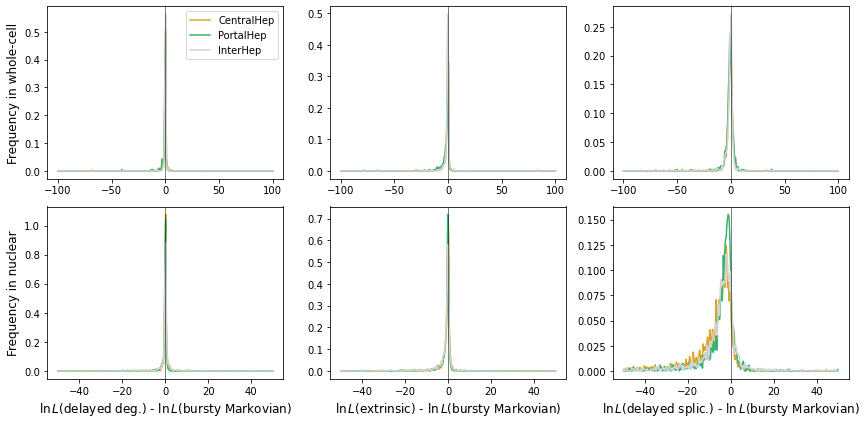

In [100]:
fig1,ax1=plt.subplots(2,3,figsize=(12,6))
fs=12
alf =0.5
colors = ('goldenrod','mediumseagreen','lightgray')

kdes_liver = np.empty((3,3,2),dtype=object)

for model_index,mi in enumerate([[2,1],[0,1],[3,1]]):
    print(model_names[model_index])
    for cluster_index,di in enumerate([[0,3],[1,4],[2,5]]):
        print(cluster_names[cluster_index])
        
        lim = 100
        linsp_n = 300
        sc_lr=model_logL[di[0],mi[0]] - model_logL[di[0],1]
        sc_lr = sc_lr[np.abs(sc_lr)<lim]
        sc_kde=scipy.stats.gaussian_kde(sc_lr,bw_method=0.01)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[0,model_index].plot(x,sc_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        
        lim = 50
        sn_lr=model_logL[di[1],mi[0]] - model_logL[di[1],1]
        sn_lr = sn_lr[np.abs(sn_lr)<lim]
        sn_kde=scipy.stats.gaussian_kde(sn_lr,bw_method=0.01)
        x = np.linspace(-lim,lim,linsp_n)
        ax1[1,model_index].plot(x,sn_kde(x),\
                             label=f'{cluster_names[cluster_index]}',color=colors[cluster_index])
        
        kdes_liver[model_index,cluster_index,0] = sc_kde
        kdes_liver[model_index,cluster_index,1] = sn_kde
        
        

    for i in range(2):
        yl = ax1[i,model_index].get_ylim()
        ax1[i,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[i,model_index].set_ylim(yl)
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
ax1[0,0].legend()
fig1.tight_layout()
plt.savefig('./fig/likelihood_ratio_liver.png',dpi=450)

## Joint

Plot KDEs of likelihood ratios.

In [101]:
kdes_allen.shape

(3, 2, 2)

In [102]:
kdes_liver.shape

(3, 3, 2)

In [103]:
kdes = np.concatenate((kdes_allen,kdes_liver),axis=1)

In [104]:
cluster_names = ['Glutamatergic','GABAergic','CentralHep','PortalHep','InterHep']

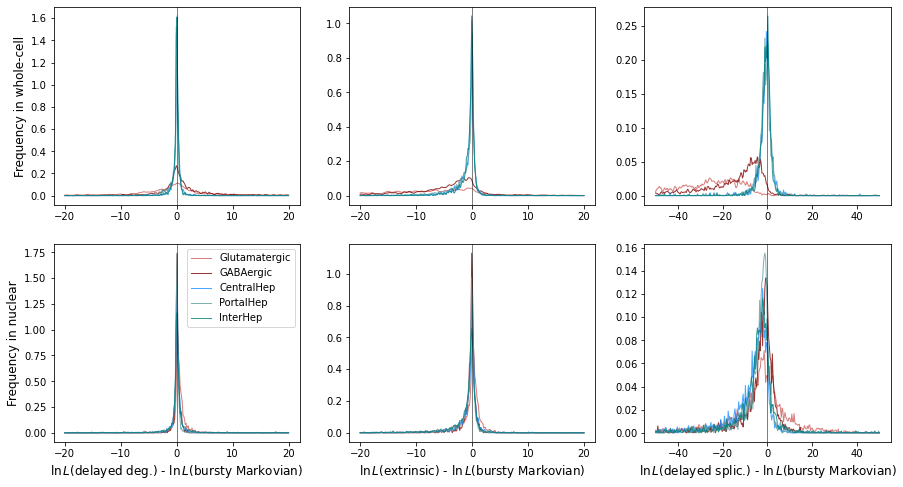

In [105]:
fig1,ax1=plt.subplots(2,3,figsize=(15,8))
colors = ('indianred','maroon','dodgerblue','cadetblue','teal')

for tech in range(2):
    for model_index in range(3):
        for cluster_index in range(5):
            kde = kdes[model_index,cluster_index,tech]
            lim = 50 if model_index==2 else 20
            linsp_n = 300
            x = np.linspace(-lim,lim,linsp_n)
            ax1[tech,model_index].plot(x,kde(x),\
                                 label=f'{cluster_names[cluster_index]}',\
                                 color=colors[cluster_index],alpha=0.8,linewidth=1)

        yl = ax1[tech,model_index].get_ylim()
        ax1[tech,model_index].plot([0,0],yl,'k-',linewidth=.5)
        ax1[tech,model_index].set_ylim(yl)

for model_index in range(3):
    ax1[1,model_index].set_xlabel(fr'$\ln L$({model_names[model_index]}) - $\ln L$(bursty Markovian)',fontsize=fs)
ax1[1,0].legend()
ax1[0,0].set_ylabel('Frequency in whole-cell',fontsize=fs)
ax1[1,0].set_ylabel('Frequency in nuclear',fontsize=fs)
plt.savefig('./fig/likelihood_ratio.png',dpi=450)



In [106]:
sr_arr_full[0][0].sp.gradient_params

{'max_iterations': 15, 'init_pattern': 'moments', 'num_restarts': 5}

In [107]:
sr_arr_full[0][0].n_genes

3000

In [108]:
tot_wc = np.concatenate((tot_wc_allen,tot_wc_liver),axis=0)
tot_nuc = np.concatenate((tot_nuc_allen,tot_nuc_liver),axis=0)

Plot the unspliced count fractions.

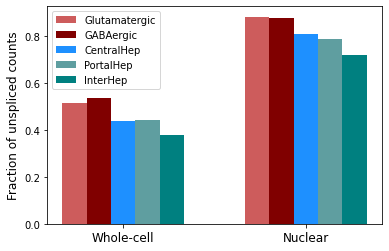

In [141]:
plt.bar(np.arange(5)*0.2-0.4,tot_wc[:,0],0.2,color=colors)
plt.bar(np.arange(5)*0.2+1.1,tot_nuc[:,0],0.2,color=colors)
plt.xticks([0,1.5],('Whole-cell','Nuclear'),fontsize=12)
plt.ylabel('Fraction of unspliced counts',fontsize=12)
from matplotlib.patches import Rectangle

handles = [Rectangle((0,0),1,1,color=c,ec="None") for c in colors]
plt.legend(handles, cluster_names)
plt.savefig('./fig/U_fraction.png',dpi=450)
